## Without Clustering

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw = pd.read_csv('Nomis Solutions_Data Part I.csv')
raw.rename(columns=str.lower, inplace=True)

In [3]:
data = raw.drop(raw.index[-3:])
data.drop(['approve date', 'previous rate'], axis=1, inplace=True)
data['diff'] = data['rate'] - data['competition rate']
data = pd.get_dummies(data)
data.head()

,tier,fico,term,amount,competition rate,outcome,rate,cost of funds,partner bin,diff,car type_N,car type_R,car type_U
0,3.0,695.0,72.0,35000.0,6.25,0.0,7.49,1.8388,1.0,1.24,1,0,0
1,1.0,751.0,60.0,40000.0,5.65,0.0,5.49,1.8388,3.0,-0.16,1,0,0
2,1.0,731.0,60.0,18064.0,5.65,0.0,5.49,1.8388,3.0,-0.16,1,0,0
3,4.0,652.0,72.0,15415.0,6.25,0.0,8.99,1.8388,3.0,2.74,1,0,0
4,1.0,730.0,48.0,32000.0,5.65,0.0,5.49,1.8388,1.0,-0.16,1,0,0


In [4]:
# segregate funded loan and lost sale
train = data[data['outcome']==1].drop(['outcome', 'rate'], axis=1)
test = data[data['outcome']==0].drop(['outcome', 'rate'], axis=1)

In [5]:
# Normalize train data and test data
fico_mean, fico_std = train['fico'].mean(), train['fico'].std()
amount_mean, amount_std = train['amount'].mean(), train['amount'].std()
cof_mean, cof_std = train['cost of funds'].mean(), train['cost of funds'].std()

train[['fico','amount', 'cost of funds']] = \
train[['fico','amount', 'cost of funds']].apply(lambda df:(df-df.mean())/df.std())
train['term'] = train['term'] / 36

test['fico'] = (test['fico'] - fico_mean) / fico_std
test['amount'] = (test['amount'] - amount_mean) / amount_std
test['cost of funds'] = (test['cost of funds'] - cof_mean) /  cof_std
test['term'] = test['term'] / 36

train.head(10)

,tier,fico,term,amount,competition rate,cost of funds,partner bin,diff,car type_N,car type_R,car type_U
27,1.0,0.351378,1.000000,0.037018,4.95,1.875102,1.0,-0.10,1,0,0
36,1.0,0.556511,1.666667,1.914367,5.65,1.875102,1.0,-0.16,1,0,0
37,1.0,1.149119,1.333333,-0.730788,5.85,1.875102,3.0,0.00,0,0,1
43,2.0,-0.081682,1.666667,0.057565,5.65,1.875102,3.0,-0.26,1,0,0
54,2.0,-0.628705,2.000000,0.616778,6.25,1.875102,3.0,0.74,1,0,0
56,1.0,0.647682,1.833333,-0.703645,6.45,1.875102,1.0,0.04,0,0,1
79,4.0,-1.585994,1.666667,0.014173,5.85,1.875102,1.0,2.14,0,0,1
83,1.0,0.875608,2.000000,-0.887000,6.45,1.875102,1.0,0.24,0,0,1
85,1.0,1.171912,2.000000,0.135599,6.25,1.875102,1.0,0.34,1,0,0
95,2.0,-0.605912,1.666667,-0.243069,5.85,1.875102,1.0,0.34,0,0,1


In [6]:
# Extract independent variable and dependdent variable
X = train.drop('diff',axis=1)
Y = train['diff']
test_X = test.drop('diff',axis=1)
test_Y = test['diff']

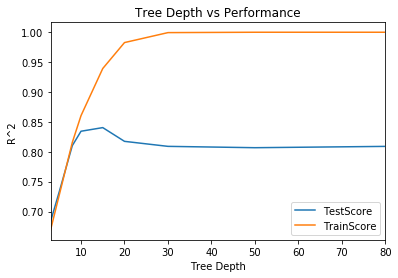

In [7]:
# Find appropriate hyperparameter
deplist = [3,5,8,10,15,20,30,50,80]
trainscore=[]
testscore=[]
for dep in deplist:
    model = DecisionTreeRegressor(max_depth=dep)
    model.fit(X,Y)
    trainscore.append(model.score(X,Y))
    testscore.append(model.score(test_X,test_Y))
result = pd.DataFrame({'TrainScore':trainscore, 'TestScore':testscore}, index=deplist)
result.plot(title='Tree Depth vs Performance')
plt.xlabel('Tree Depth')
plt.ylabel('R^2');

In [8]:
# Apply tuned hyperparameter to DecisionTreeRegressor Model
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = DecisionTreeRegressor(max_depth=20)
model.fit(x_train,y_train)
print("Feature importance is","\n",model.feature_importances_)
print("The coefficient of determination, R^2, of train set is {:.3f}.".format(model.score(x_train,y_train)))
print("The coefficient of determination, R^2, of test set is {:.3f}.".format(model.score(x_test,y_test)))
print("The coefficient of determination, R^2, of lost sale set is {:.3f}.".format(model.score(test_X,test_Y)))

Feature importance is 
 [ 0.64539839  0.03937284  0.03330765  0.04804308  0.09908992  0.09572636
  0.00690544  0.00555749  0.01653496  0.01006386]
The coefficient of determination, R^2, of train set is 0.985.
The coefficient of determination, R^2, of test set is 0.746.
The coefficient of determination, R^2, of lost sale set is 0.784.


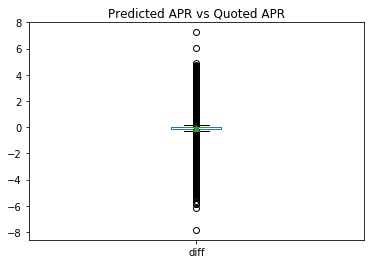

In [9]:
# Plot predict result for adjusted APR of lost sale
examine = model.predict(test_X) - test_Y
examine.plot(kind='box', notch=True, bootstrap=1000, showmeans=True, title='Predicted APR vs Quoted APR')

In [10]:
# Distribution of predict result for adjusted APR of lost sale

# examine[examine <= examine.quantile(0.25)].count()
pd.qcut(examine, 4,precision=8,labels=['0~25%','25%~50%','50%~75%','75%~100%'],duplicates='drop').value_counts()

25%~50%     72900
0~25%       40688
75%~100%    40561
50%~75%      8149
Name: diff, dtype: int64

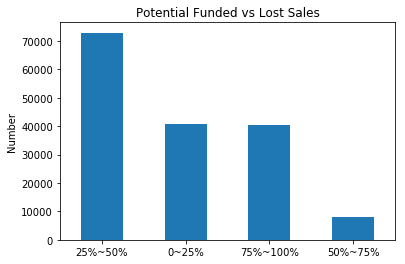

In [11]:
pd.qcut(examine,4,labels=['0~25%','25%~50%','50%~75%','75%~100%'],precision=8,duplicates='drop')\
.value_counts()\
.plot(kind='bar',rot=0, title='Potential Funded vs Lost Sales')
plt.ylabel('Number');

## With Clustering

In [12]:
clus = pd.read_csv('clustered_data.csv', index_col=0)
clus.head()

,tier,fico,term,amount,previous_rate,competition_rate,outcome,rate,cost_of_funds,partner_bin,car_type_N,car_type_R,car_type_U,cluster_number
0,3.0,695.0,72.0,35000.0,0.0,6.25,0.0,7.49,1.8388,1.0,1.0,0.0,0.0,11.0
1,1.0,751.0,60.0,40000.0,0.0,5.65,0.0,5.49,1.8388,3.0,1.0,0.0,0.0,25.0
2,1.0,731.0,60.0,18064.0,0.0,5.65,0.0,5.49,1.8388,3.0,1.0,0.0,0.0,36.0
3,4.0,652.0,72.0,15415.0,0.0,6.25,0.0,8.99,1.8388,3.0,1.0,0.0,0.0,73.0
4,1.0,730.0,48.0,32000.0,0.0,5.65,0.0,5.49,1.8388,1.0,1.0,0.0,0.0,1.0


In [13]:
data2 = clus.drop(['previous_rate'], axis=1)
data2.dropna(axis=0, inplace=True)
data2['diff'] = data2['rate'] - data2['competition_rate']

In [14]:
# segregate funded loan and lost sale
train2 = data2[data2['outcome']==1].drop(['outcome', 'rate'], axis=1)
test2 = data2[data2['outcome']==0].drop(['outcome', 'rate'], axis=1)

In [15]:
# Normalize train data and test data
fico_mean_2, fico_std_2 = train2['fico'].mean(), train2['fico'].std()
amount_mean_2, amount_std_2 = train2['amount'].mean(), train2['amount'].std()
cof_mean_2, cof_std_2 = train2['cost_of_funds'].mean(), train2['cost_of_funds'].std()

train2[['fico','amount', 'cost_of_funds']] = \
train2[['fico','amount', 'cost_of_funds']].apply(lambda df:(df-df.mean())/df.std())
train2['term'] = train2['term'] / 36

test2['fico'] = (test2['fico'] - fico_mean_2) / fico_std_2
test2['amount'] = (test2['amount'] - amount_mean_2) / amount_std_2
test2['cost_of_funds'] = (test2['cost_of_funds'] - cof_mean_2) /  cof_std_2
test2['term'] = test2['term'] / 36

train2.head(10)

,tier,fico,term,amount,competition_rate,cost_of_funds,partner_bin,car_type_N,car_type_R,car_type_U,cluster_number,diff
27,1.0,0.351376,1.000000,0.036970,4.95,1.875533,1.0,1.0,0.0,0.0,63.0,-0.10
36,1.0,0.556524,1.666667,1.914332,5.65,1.875533,1.0,1.0,0.0,0.0,89.0,-0.16
37,1.0,1.149173,1.333333,-0.730842,5.85,1.875533,3.0,0.0,0.0,1.0,48.0,0.00
43,2.0,-0.081714,1.666667,0.057517,5.65,1.875533,3.0,1.0,0.0,0.0,68.0,-0.26
54,2.0,-0.628775,2.000000,0.616735,6.25,1.875533,3.0,1.0,0.0,0.0,81.0,0.74
56,1.0,0.647701,1.833333,-0.703698,6.45,1.875533,1.0,0.0,0.0,1.0,82.0,0.04
79,4.0,-1.586132,1.666667,0.014125,5.85,1.875533,1.0,0.0,0.0,1.0,63.0,2.14
83,1.0,0.875643,2.000000,-0.887055,6.45,1.875533,1.0,0.0,0.0,1.0,52.0,0.24
85,1.0,1.171967,2.000000,0.135551,6.25,1.875533,1.0,1.0,0.0,0.0,35.0,0.34
95,2.0,-0.605981,1.666667,-0.243119,5.85,1.875533,1.0,0.0,0.0,1.0,59.0,0.34


In [16]:
# Extract independent variable and dependdent variable
X2 = train2.drop('diff',axis=1)
Y2 = train2['diff']
test_X2 = test2.drop('diff',axis=1)
test_Y2 = test2['diff']

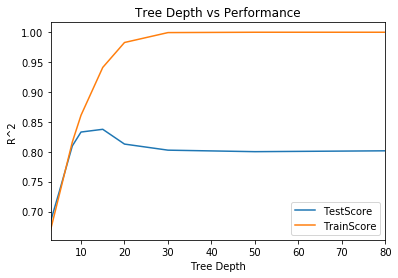

In [17]:
# Find appropriate hyperparameter
deplist = [3,5,8,10,15,20,30,50,80]
trainscore2=[]
testscore2=[]
for dep in deplist:
    model2 = DecisionTreeRegressor(max_depth=dep)
    model2.fit(X2,Y2)
    trainscore2.append(model2.score(X2,Y2))
    testscore2.append(model2.score(test_X2,test_Y2))
result2 = pd.DataFrame({'TrainScore':trainscore2, 'TestScore':testscore2}, index=deplist)
result2.plot(title='Tree Depth vs Performance')
plt.xlabel('Tree Depth')
plt.ylabel('R^2');

In [18]:
# Apply tuned hyperparameter to DecisionTreeRegressor Model
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.2, random_state=42)
model2 = DecisionTreeRegressor(max_depth=20)
model2.fit(x_train2,y_train2)
print("Feature importance is","\n",model2.feature_importances_)
print("The coefficient of determination, R^2, of train set is {:.3f}.".format(model2.score(x_train2,y_train2)))
print("The coefficient of determination, R^2, of test set is {:.3f}.".format(model2.score(x_test2,y_test2)))
print("The coefficient of determination, R^2, of lost sale set is {:.3f}.".format(model2.score(test_X2,test_Y2)))

Feature importance is 
 [ 0.64533431  0.0399441   0.02630945  0.04336815  0.10766394  0.08285798
  0.00542071  0.00551768  0.01889403  0.00620806  0.01848159]
The coefficient of determination, R^2, of train set is 0.984.
The coefficient of determination, R^2, of test set is 0.744.
The coefficient of determination, R^2, of lost sale set is 0.781.


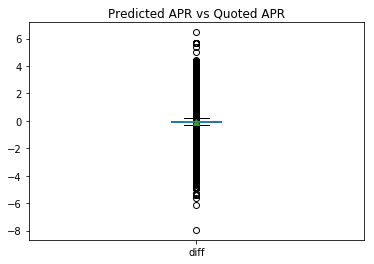

In [19]:
# Plot predict result for adjusted APR of lost sale
examine2 = model2.predict(test_X2) - test_Y2
examine2.plot(kind='box', notch=True, bootstrap=1000, showmeans=True, title='Predicted APR vs Quoted APR')

In [20]:
# Distribution of predict result for adjusted APR of lost sale
pd.qcut(examine2, 4,precision=8,labels=['0~25%','25%~50%','50%~75%','75%~100%'],duplicates='drop').value_counts()

25%~50%     71959
0~25%       40646
75%~100%    39190
50%~75%     10496
Name: diff, dtype: int64

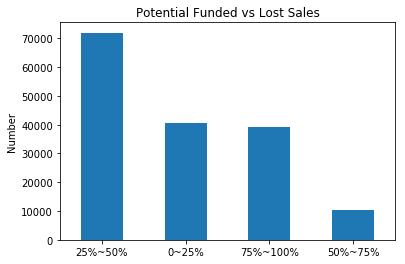

In [21]:
pd.qcut(examine2,4,labels=['0~25%','25%~50%','50%~75%','75%~100%'],precision=8,duplicates='drop')\
.value_counts()\
.plot(kind='bar',rot=0, title='Potential Funded vs Lost Sales')
plt.ylabel('Number');

## Conclusion

By applying DecesionTreeRegressor model to lost sales, almost half of the total predicted APR, which is also within middle 50% of predicted APR range, is lower than real quoted APR. The reason why the customer didn't choose to proceed may result from higher quoted APR. However, for the other half, it can be noticed that real quoted APR deviated from predicted APR drastically - which means original quotation may not be accurate. Thus, if we delpoy the model to lost sales, we shall anticipate an increase of funded loan. 